# Part 1: Introduction to Foundational Quantum Computing Tasks

1. Sampling from quantum circuits (plus an exercise)

2. Estimating expectation values of observables (plus an exercise)

# 1. Sampling from quantum circuits

## ! EXERCISE !

**Sample from a circuit with entangling gates.**

1. Create a circuit with both single and two-qubit entangling gates of your choosing (check out the [Qiskit Circuit Library of standard gates](https://qiskit.org/documentation/apidoc/circuit_library.html)). For example, perhaps you might build a [Bell state](https://en.wikipedia.org/wiki/Bell_state) or a [GHZ state](https://en.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_state).
2. Measure all qubits in the computational basis
3. Run the circuit on the `qasm_simulator` backend
4. Plot a histogram of measurement counts (you can use Qiskit's `plot_histogram` functionality documented [here](https://qiskit.org/documentation/stubs/qiskit.visualization.plot_histogram.html))

Is the output what you expected?

### A Solution...

        ┌───┐           ░ ┌─┐      
   q_0: ┤ H ├──■────────░─┤M├──────
        └───┘┌─┴─┐      ░ └╥┘┌─┐   
   q_1: ─────┤ X ├──■───░──╫─┤M├───
             └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ──────────┤ X ├─░──╫──╫─┤M├
                  └───┘ ░  ║  ║ └╥┘
meas: 3/═══════════════════╩══╩══╩═
                           0  1  2 


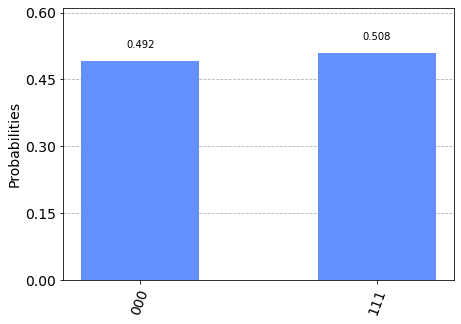

In [1]:
# import functionality from qiskit for building and running circuits
from qiskit import QuantumCircuit, BasicAer, transpile

# here we'll create a GHZ state
circuit = QuantumCircuit(3)
circuit.h(0)
circuit.cnot(0,1)
circuit.cnot(1,2)
circuit.measure_all()

print(circuit.draw())

# select a quantum backend and run the circuit
backend = BasicAer.get_backend('qasm_simulator')
shots = 2**13

job = backend.run(transpile(circuit, backend), shots=shots)
result = job.result()
counts = result.get_counts()

from qiskit.visualization import plot_histogram
plot_histogram(counts)

# 2. Estimating expectation values 

### Example: Pauli $Z$ operator

Recall that $Z = |0\rangle\langle0| - |1\rangle\langle1|$

This means we can write the expectation of $Z$ as: 

\begin{equation}
\begin{split}
   \langle\psi|Z|\psi\rangle & = \langle\psi|0\rangle\langle0|\psi\rangle-\langle\psi|1\rangle\langle1|\psi\rangle \\
                             & = |\langle0|\psi\rangle|^2 - |\langle1|\psi\rangle|^2 \\
                             & = p(0) - p(1)
\end{split}
\end{equation}

Therefore, to estimate the expectation value of $Z$, we: 

1. Prepare a circuit representing $|\psi\rangle$
2. Measure in the computational ($Z$) basis to get the probabilities $|\langle0|\psi\rangle|^2, |\langle1|\psi\rangle|^2$
3. Subtract the probability to measure "1" from "0"

## ! EXERCISE !


**Compute the expectation value of the Pauli $X$ and $Y$ operators in the states $|1\rangle, |+\rangle$.**

Hint: these operators can be related to $Z$ via the following transformations: $HZH=X$ and $SHZHS^\dagger=Y$. How does this modify the math we saw above for the expectation value (and hence the circuit implementation)?

Check out [this chapter of the Qiskit Textbook for info about using single-qubit gates](https://qiskit.org/textbook/ch-states/single-qubit-gates.html).

### A Solution...

Let's start with $X$ and modify the math for the expectation value. 

$$ 
\begin{split}
\langle\psi|X|\psi\rangle & = \langle\psi|HZH|\psi\rangle \\
                          & = \langle\psi H|0\rangle\langle0|H\psi\rangle-\langle\psi H|1\rangle\langle1|H\psi\rangle\\
                          & = |\langle0|H\psi\rangle|^2 - |\langle1|H\psi\rangle|^2
\end{split}
$$

Therefore, to estimate this expectation value, we apply a post-rotation ($H$) to the circuit $\psi$ and then measure in the computational basis.

Similarly for the expectation value of $Y$:

$$ 
\begin{split}
\langle\psi|Y|\psi\rangle & = \langle\psi|SHZHS^\dagger|\psi\rangle \\
                          & = \langle\psi SH|0\rangle\langle0|HS^\dagger\psi\rangle-\langle\psi SH|1\rangle\langle1|HS^\dagger\psi\rangle\\
                          & = |\langle0|HS^\dagger\psi\rangle|^2 - |\langle1|HS^\dagger\psi\rangle|^2
\end{split}
$$
In this case, we add the post-rotation $HS^\dagger$ to the circuit.

In [2]:
# defining the state |1>
import numpy as np
a = 0
b = 1
state = np.array([a,b])
norm = np.linalg.norm(state)
normalized_state_ONE = state/norm

print(normalized_state_ONE)

[0. 1.]


In [3]:
# define the state |+>
a = 0.70710678 # 1/sqrt(2)
b = 0.70710678
state = np.array([a,b])
norm = np.linalg.norm(state)
normalized_state_PLUS = state/norm

print(normalized_state_PLUS)

[0.70710678 0.70710678]


**Let's look at the eigenstate for the $X$ gate**

In [4]:
# define the Pauli X operator
x = np.array([[0, 1],
             [1, 0]])


Eigensystem of X:
[-1.  1.]
[[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]


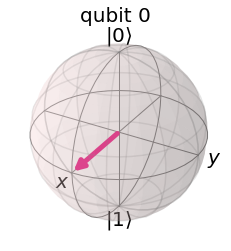

In [5]:
from qiskit.visualization import plot_state_city, plot_bloch_multivector
x_eigenvals, x_eigenvecs = np.linalg.eigh(x)

print('\nEigensystem of X:')
print(x_eigenvals)
print(x_eigenvecs)

plot_bloch_multivector(x_eigenvecs[:,1])

**To measure $\langle1|X|1\rangle$, add a post rotation ($H$)**

In [6]:
circuit = QuantumCircuit(1)
circuit.initialize(normalized_state_ONE)
circuit.h(0)
circuit.measure_all()
print(circuit)

        ┌─────────────────┐┌───┐ ░ ┌─┐
     q: ┤ Initialize(0,1) ├┤ H ├─░─┤M├
        └─────────────────┘└───┘ ░ └╥┘
meas: 1/════════════════════════════╩═
                                    0 


In [7]:
job = backend.run(transpile(circuit, backend), shots=shots)
result = job.result()

counts = result.get_counts()
print(counts)

expval = (counts.get('0',0)-counts.get('1',0)) / shots
print('expectation value: {}'.format(expval))

{'1': 4153, '0': 4039}
expectation value: -0.013916015625


This makes sense because $\langle1|X|1\rangle = |\langle0|H|1\rangle|^2-|\langle1|H|1\rangle|^2 = 1/2-1/2=0$. Note also, that the state $|1\rangle$ is an equal superposition of the two eigenstates of the operator $X$: $|1\rangle = 1/\sqrt(2) (|+\rangle - |-\rangle)$, so we expect the expectation value to vanish.

**To measure $\langle+|X|+\rangle$, add a post rotation ($H$)**

In [8]:
circuit = QuantumCircuit(1)
circuit.initialize(normalized_state_PLUS)
circuit.h(0)
circuit.measure_all()
print(circuit)

        ┌─────────────────────────────┐┌───┐ ░ ┌─┐
     q: ┤ Initialize(0.70711,0.70711) ├┤ H ├─░─┤M├
        └─────────────────────────────┘└───┘ ░ └╥┘
meas: 1/════════════════════════════════════════╩═
                                                0 


In [9]:
job = backend.run(transpile(circuit, backend), shots=shots)
result = job.result()

counts = result.get_counts()
print(counts)

expval = (counts.get('0',0)-counts.get('1',0)) / shots
print('expectation value: {}'.format(expval))

{'0': 8192}
expectation value: 1.0


This makes sense because $\langle+|X|+\rangle = |\langle0|H|+\rangle|^2-|\langle1|H|+\rangle|^2 = |\langle0|0\rangle|^2-|\langle1|0\rangle|^2 = 1-0=1$. And also because the state $|+\rangle$ is an _eigenstate_ of the operator $X$ with eigenvalue $1$.

**Now, repeat this for the $Y$ gate, adding in the correct post rotation ($HS^\dagger$)**

In [10]:
circuit = QuantumCircuit(1)
circuit.initialize(normalized_state_ONE)
circuit.sdg(0)
circuit.h(0)
circuit.measure_all()
print(circuit)

job = backend.run(transpile(circuit, backend), shots=shots)
result = job.result()
counts = result.get_counts()
print(counts)
expval = (counts.get('0',0)-counts.get('1',0)) / shots
print('expectation value: {}'.format(expval))

        ┌─────────────────┐┌─────┐┌───┐ ░ ┌─┐
     q: ┤ Initialize(0,1) ├┤ Sdg ├┤ H ├─░─┤M├
        └─────────────────┘└─────┘└───┘ ░ └╥┘
meas: 1/═══════════════════════════════════╩═
                                           0 
{'1': 4112, '0': 4080}
expectation value: -0.00390625


For similar reasons as with $X$, we expect this to vanish because $|1\rangle$ is an equal superposition of the eigenstates of the operator $Y$.

In [11]:
circuit = QuantumCircuit(1)
circuit.initialize(normalized_state_PLUS)
circuit.sdg(0)
circuit.h(0)
circuit.measure_all()
print(circuit)

job = backend.run(transpile(circuit, backend), shots=shots)
result = job.result()
counts = result.get_counts()
print(counts)
expval = (counts.get('0',0)-counts.get('1',0)) / shots
print('expectation value: {}'.format(expval))

        ┌─────────────────────────────┐┌─────┐┌───┐ ░ ┌─┐
     q: ┤ Initialize(0.70711,0.70711) ├┤ Sdg ├┤ H ├─░─┤M├
        └─────────────────────────────┘└─────┘└───┘ ░ └╥┘
meas: 1/═══════════════════════════════════════════════╩═
                                                       0 
{'1': 4047, '0': 4145}
expectation value: 0.011962890625


In this case also, the expectation value vanishes because $|+\rangle$ is an equal superposition of the eigenstates of the operator $Y$.

In [12]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright